# Lab Assignment Five: Wide and Deep Networks
by:
* Hayden Donofrio
* Riley Bates
* Andrew Breslauer
* Chandler Choate

## Section 1: Preparation

In [68]:
#load in the dataset
import pandas as pd
import numpy as np
df = pd.read_csv('weatherAUS.csv')
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RISK_MM,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,0.0,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,0.0,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,0.0,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,1.0,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,0.2,No


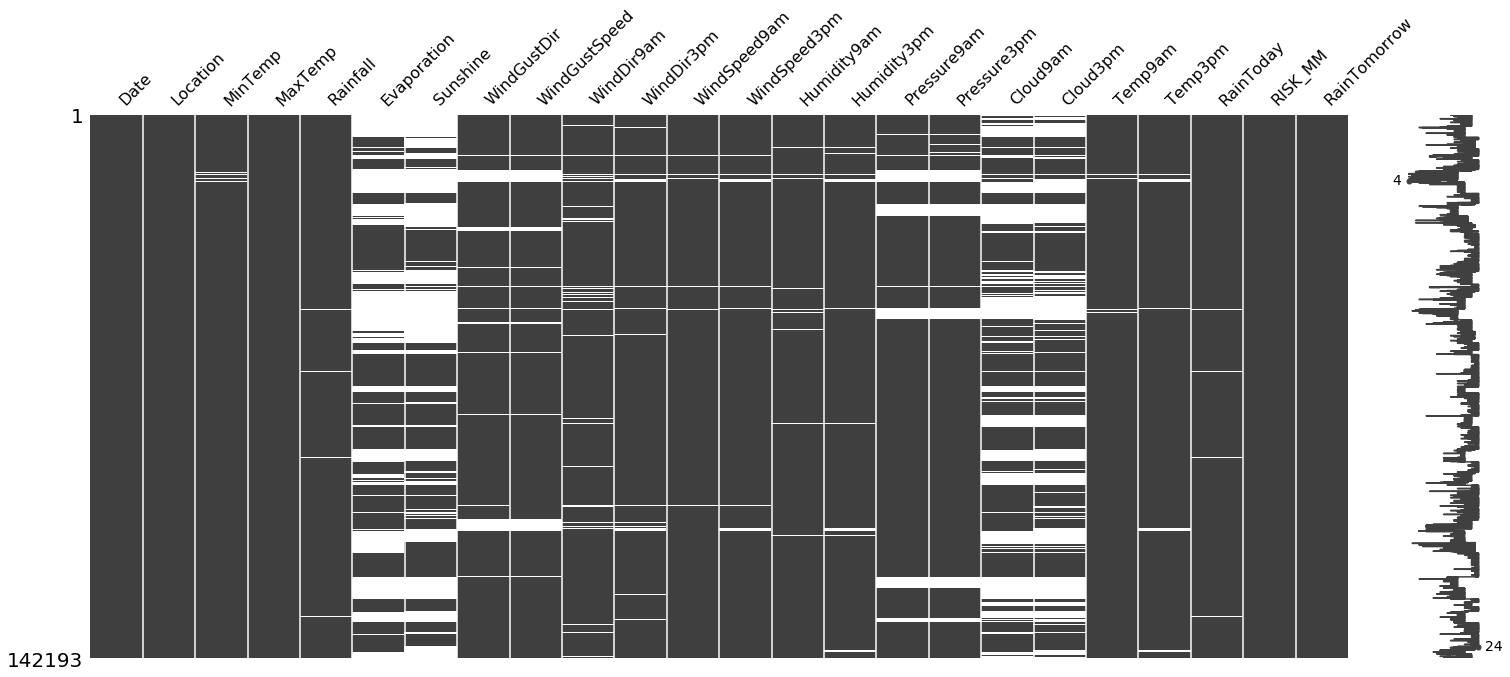

In [69]:
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline 

import missingno as mn

mn.matrix(df)

### Remove missing Data

The four columns removed below are missing data almost half of the time and there is no great way to impute these values, so we will unfortunately drop them altogether. Although this data would undoubtedly be nice to have, it is not as critical for predicting precipitation tomorrow as other values such as temperatures, humidities and air pressure. 

Riley is taking a meteorology class this semester which provides some (beginner level) additional insight on how current weather conditions may indicate incoming rain.

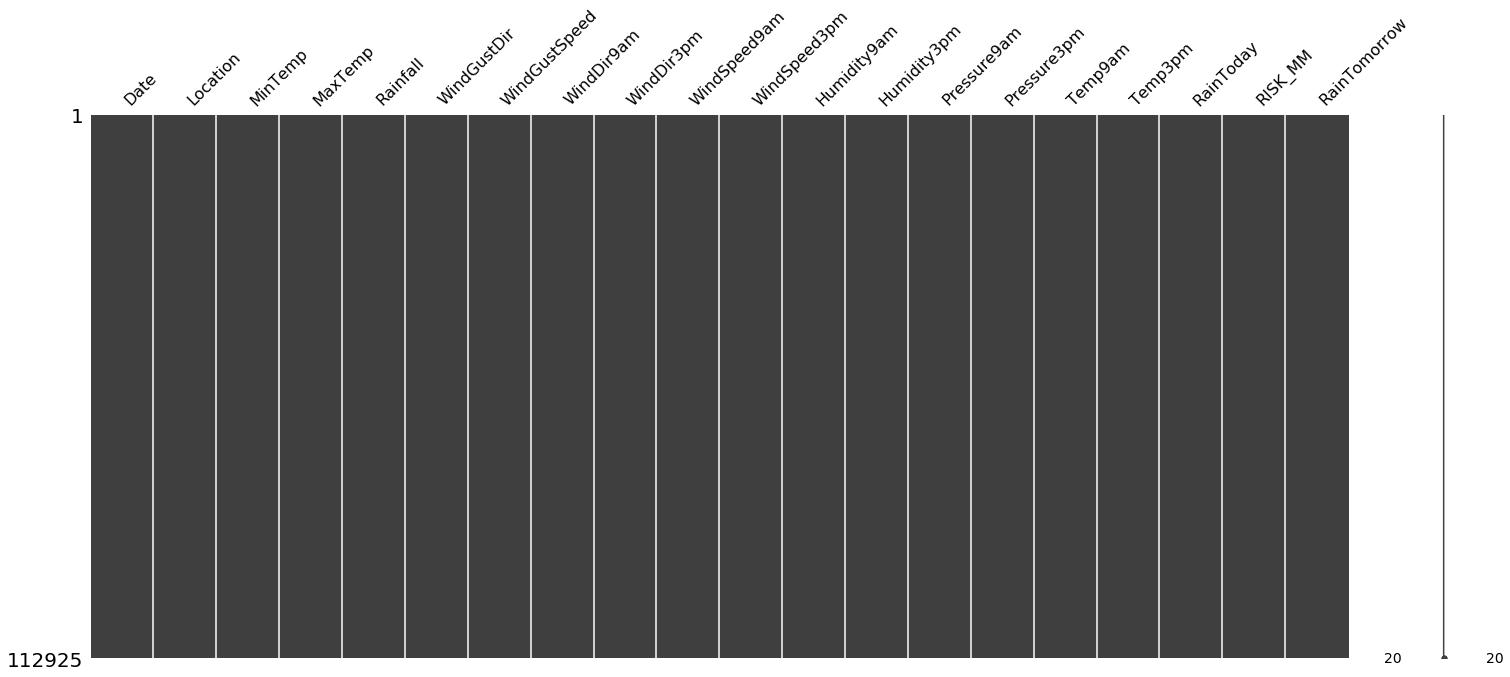

In [70]:
df = df.drop(columns=['Evaporation', 'Sunshine','Cloud9am','Cloud3pm'])
df.replace(to_replace=' ?',value=np.nan, inplace=True)
df.dropna(inplace=True)
df.reset_index()
mn.matrix(df)

In [71]:
#lets split into train and test, were gonna do a standard 80/20 split
# this will be our y column
di = {"No": 0, "Yes": 1}
df = df.replace({"RainTomorrow": di})
y = df['RainTomorrow']
df.drop(columns=['RainTomorrow'])

,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RISK_MM
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,WSW,46.0,W,WSW,19.0,26.0,38.0,30.0,1007.6,1008.7,21.0,23.2,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NE,24.0,SE,E,11.0,9.0,45.0,16.0,1017.6,1012.8,18.1,26.5,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,W,41.0,ENE,NW,7.0,20.0,82.0,33.0,1010.8,1006.0,17.8,29.7,No,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142188,2017-06-20,Uluru,3.5,21.8,0.0,E,31.0,ESE,E,15.0,13.0,59.0,27.0,1024.7,1021.2,9.4,20.9,No,0.0
142189,2017-06-21,Uluru,2.8,23.4,0.0,E,31.0,SE,ENE,13.0,11.0,51.0,24.0,1024.6,1020.3,10.1,22.4,No,0.0
142190,2017-06-22,Uluru,3.6,25.3,0.0,NNW,22.0,SE,N,13.0,9.0,56.0,21.0,1023.5,1019.1,10.9,24.5,No,0.0
142191,2017-06-23,Uluru,5.4,26.9,0.0,N,37.0,SE,WNW,9.0,9.0,53.0,24.0,1021.0,1016.8,12.5,26.1,No,0.0


In [72]:
#one hot encode here
df_copy = df
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
for col in categorical_cols:
    one_hot = pd.get_dummies(df[col],prefix=col, drop_first=True)
    df = df.join(one_hot)
df = df.drop(columns=categorical_cols)
df.head()

,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
0,2008-12-01,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,...,0,0,0,0,0,0,0,0,1,0
1,2008-12-02,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,...,0,0,0,0,0,0,0,0,0,1
2,2008-12-03,12.9,25.7,0.0,46.0,19.0,26.0,38.0,30.0,1007.6,...,0,0,0,0,0,0,0,0,0,1
3,2008-12-04,9.2,28.0,0.0,24.0,11.0,9.0,45.0,16.0,1017.6,...,0,0,0,0,0,0,0,0,0,0
4,2008-12-05,17.5,32.3,1.0,41.0,7.0,20.0,82.0,33.0,1010.8,...,0,1,0,0,0,0,0,0,0,0


### Final Dataset

The final dataset we are left to work with has had the Evaporation, Sunshine, Cloud9am and Cloud3pm columns dropped. Categorical columns have been one hot encoded, including Location, WindGustDir, WindDir9am, and WindDir3pm. There are many important features to look at, and even meteorologists have trouble predicting rain sometimes, but the main columns we will look at include the temperature reading, humidity, and rain today. Rain today may be a great aspect of the dataset to memorize since often a storm may last for multiple days, or bad weather persist in an area. <br>

Pressure is also a great indicator of incoming rain, as pressure fluctuations are present when fronts come through; warm fronts generally bring gentle rain and cold fronts bring thunderstorms. Low pressures also may indicate a midlatitude cyclone (a low pressure system) that almost always bring precipitation.

### Cross-product Features

Our dataset has a large selection of variables that should be somewhat related, such as MinTemp and MaxTemp. Average differences between the two is probably pretty steady, so that is one set of crossed columns that makes sense. That same logic can be applied to the WindGustDirection and WindGustSpeed, or Pressure9am and Pressure3pm, or the other time-oriented variables (Temp9am and Temp3pm, Humidity, WindDir, etc). After all of those are merged, there are other weather related variables that could be crossed, such as the Temp9am/Temp3pm collective and "RainToday" to examine the relationship between these.

### Evaluation Metric

We know that precision takes false positives into account and recall takes false negatives into account. Using just one of these indicators isn't perfect, because we do care about both false positive and negative cases in our business scenario. False positives are not ideal (predicting rain tomorrow but actually no rain) but as a human being who has been on the other end of this, false negatives are much, much worse (predicting no rain and there being rain) because you aren't prepared with a jacket or umbrella. From the perspective of our business case, these false predictions are very important to take into account.

Since false negative and false positives have a negative effect on business (reputation or viewings as a meteorologist or wherever this model would be deployed) so F1 score will probably be the best performance metric to use in order to seek a balance between precision and recall.

### Training and Testing Division Method

In [73]:
#the goal here is the simple binary classification, is it going to rain tomorrow or not?
#lets see how many rows there are
categorical_cols = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm', "RainToday"]
df.groupby(['RainTomorrow']).count()

,Date,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,...,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW
RainTomorrow,,,,,,,,,,,,,,,,,,,,,
0,87906,87906,87906,87906,87906,87906,87906,87906,87906,87906,...,87906,87906,87906,87906,87906,87906,87906,87906,87906,87906
1,25019,25019,25019,25019,25019,25019,25019,25019,25019,25019,...,25019,25019,25019,25019,25019,25019,25019,25019,25019,25019


After removing all missing data, we have about 90,000 entries for no rain tomorrow and about 25,000 for rain. This is plenty of data for each class, so we believe that using a test/train split would be the best method of division to balance computation time for a fairly large dataset such as this.

We would mainly use K-fold subsets is to prevent overfitting due to data not being stratified. This is a huge danger in the train/test split method - you have to ensure that the split is random, and is representative of the entire dataset. However, we are working with a fairly large dataset that would have to be retrained fairly often in real practice to predict possible precipitation as weather conditions change. The main disadvantage of K-fold validation is that the training algorithm has to be rerun from scratch k times, which means it is very computationally expensive.

For this reason, we believe that using a stratified train/test 80% split is a fair balance of computation and time constraints while also avoiding overfitting too much to our training data.

In [74]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df, y, test_size = .80)
encoded_test, encoded_train, encoded_y_test, encoded_y_train = train_test_split(df_copy, y, test_size = .80)
print(encoded_y_train, encoded_train)

87790     1
75519     0
117078    0
118127    0
137283    1
         ..
109605    0
54344     0
81150     0
42413     0
42752     0
Name: RainTomorrow, Length: 90340, dtype: int64               Date      Location  MinTemp  MaxTemp  Rainfall WindGustDir  \
87790   2017-05-04        Cairns     20.6     29.3       0.2          SE   
75519   2016-11-04      Portland      5.5     20.9       0.0         WNW   
117078  2015-10-06  PerthAirport      4.9     21.6       0.0          NE   
118127  2009-08-25         Perth      7.1     19.1       0.0          SW   
137283  2012-04-23        Darwin     24.5     32.4       0.0          NE   
...            ...           ...      ...      ...       ...         ...   
109605  2010-09-23   Witchcliffe      6.9     25.0       0.0           N   
54344   2010-10-03      Ballarat      8.0     20.0       0.0         NNE   
81150   2015-12-28      Dartmoor      5.5     26.1       0.0          SW   
42413   2011-12-15    Wollongong     14.9     20.8       0.0

## Section 2: Modeling

In [81]:
from keras.layers import Dense, Activation, Input
from keras.layers import Embedding, Flatten, Concatenate
from keras.models import Model
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
#standard wide and deep with no cross columns

from sklearn.preprocessing import OneHotEncoder
from keras.layers import concatenate
# now let's encode the integer outputs as one hot encoded labels
ohe = OneHotEncoder()
numeric_cols = ["MinTemp", "MaxTemp", "Rainfall", "WindGustSpeed", "Humidity3pm",
                "Pressure9am", "Humidity9am", "Pressure3pm", "WindSpeed9am", "WindSpeed3pm",  
                "Temp9am", "Temp3pm", "RISK_MM"]

feature_columns = categorical_cols+numeric_cols

### Network Model 1: Simple

In [105]:
from keras.callbacks import TensorBoard

X_train_num =  encoded_train[numeric_cols].values
X_test_num = encoded_test[numeric_cols].values
embed_names = []
dfs = []
dfs_test = []
ss = StandardScaler() #do this to ALL numeric data fit_transform

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] 
embeddings = []


encoders = dict() 
for col in categorical_cols:
    encoders[col] = LabelEncoder() # save the encoder
    encoded_train[col+'_int'] = encoders[col].fit_transform(encoded_train[col])
    encoded_test[col+'_int'] = encoders[col].transform(encoded_test[col])
    
    # encode as ints for the embedding
    X_ints_train.append( encoded_train[col + "_int" ].values ) # this df_train is a vector of the integers we are one hot encoding
    X_ints_test.append( encoded_test[col + "_int"].values )
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col]) grab the last column, whats the max value +1. this value tells us how many categories there are for that variable
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    embeddings.append(x)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=20, activation='relu',name='numeric_1')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(x) )

# merge the branches together
final_concat = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_concat)

model = Model(inputs=all_inputs, outputs=final_branch)
print(model.summary())

Model: "model_13"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
WindGustDir (InputLayer)        (None, 1)            0                                            
__________________________________________________________________________________________________
WindDir9am (InputLayer)         (None, 1)            0                                            
__________________________________________________________________________________________________
WindDir3pm (InputLayer)         (None, 1)            0                                            
___________________________________________________________________________________________

/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


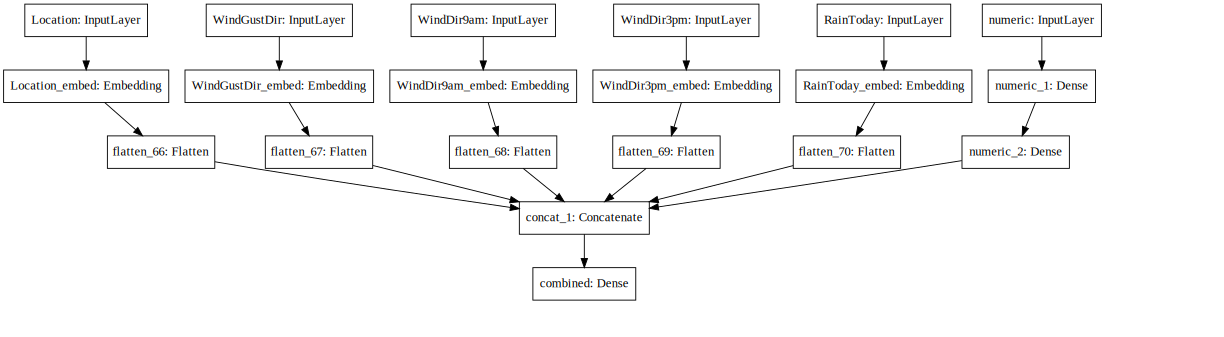

In [106]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

In [84]:
%%time
import keras
from keras import callbacks
from sklearn import metrics as mt
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

history = model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        encoded_y_train, epochs=10, batch_size=32, verbose=1, validation_data = (X_ints_test + [X_test_num], encoded_y_test),
                   callbacks = [keras.callbacks.TensorBoard(
    log_dir = 'my_log_dir',
    histogram_freq = 1,
    embeddings_freq = 1,
    embeddings_data = encoded_train,
)])

#yhat = np.round(model.predict(X_ints_test + [X_test_num]))
#print(mt.confusion_matrix(y_test,yhat),mt.accuracy_score(y_test,yhat))

//anaconda3/lib/python3.7/site-packages/keras/callbacks/tensorboard_v2.py:102: UserWarning: The TensorBoard callback does not support embeddings display when using TensorFlow 2.0. Embeddings-related arguments are ignored.
  warnings.warn('The TensorBoard callback does not support '
//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90340 samples, validate on 22585 samples
Epoch 1/10
90340/90340 [==============================] - 5s 60us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 2/10
90340/90340 [==============================] - 5s 55us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 3/10
90340/90340 [==============================] - 5s 52us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 4/10
90340/90340 [==============================] - 5s 54us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 5/10
90340/90340 [==============================] - 5s 54us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 6/10
90340/90340 [==============================] - 5s 54us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246
Epoch 7/10
90340/90340 [==============================] - 5s 52us/st

In [85]:
weights_history = []
from keras import callbacks

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback
checkpoint = callbacks.ModelCheckpoint("model.hdf5", monitor='loss', verbose=1,
    save_best_only=True, mode='auto', period=1)
class MyCallback(keras.callbacks.Callback):
    def on_batch_end(self, batch, logs):
        weights = model.get_weights()[0]
        weights_history.append(weights)


callback = MyCallback()

In [86]:
%%time

from sklearn import metrics as mt
model.compile(optimizer='adam',
              loss='mean_squared_error',
              metrics=['accuracy'])

#For Riley, LOok at the callbacks here. This is important for looking at the saved weights!
history = model.fit(X_ints_train + [X_train_num], # create a list of inputs for embeddings
        encoded_y_train, epochs=10, batch_size=32, verbose=1, validation_data = (X_ints_test + [X_test_num], encoded_y_test),
                   callbacks = [checkpoint])

//anaconda3/lib/python3.7/site-packages/tensorflow_core/python/framework/indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 90340 samples, validate on 22585 samples
Epoch 1/10
90340/90340 [==============================] - 5s 54us/step - loss: 0.7792 - accuracy: 0.2208 - val_loss: 0.7754 - val_accuracy: 0.2246

Epoch 00001: loss improved from inf to 0.77920, saving model to model.hdf5


OSError: Unable to create file (unable to truncate a file which is already open)

### Network Model 2: Extra Dense

In [103]:
from keras.callbacks import TensorBoard

X_train_num =  encoded_train[numeric_cols].values
X_test_num = encoded_test[numeric_cols].values
embed_names = []
dfs = []
dfs_test = []
ss = StandardScaler() #do this to ALL numeric data fit_transform

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
all_branch_outputs = [] 
embeddings = []


encoders = dict() 
for col in categorical_cols:
    encoders[col] = LabelEncoder() # save the encoder
    encoded_train[col+'_int'] = encoders[col].fit_transform(encoded_train[col])
    encoded_test[col+'_int'] = encoders[col].transform(encoded_test[col])
    
    # encode as ints for the embedding
    X_ints_train.append( encoded_train[col + "_int" ].values ) # this df_train is a vector of the integers we are one hot encoding
    X_ints_test.append( encoded_test[col + "_int"].values )
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col]) grab the last column, whats the max value +1. this value tells us how many categories there are for that variable
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    embeddings.append(x)
    x = Flatten()(x)
    all_branch_outputs.append(x)
    
all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))

# Triple the number of deep dense layers
dense = Dense(units=20, activation='relu',name='deep1')(all_inputs[-1])
dense = Dense(units=50,activation='relu', name='deep2')(dense)
dense = Dense(units=25,activation='relu', name='deep3')(dense)
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_2')(dense) )

# merge the branches together
final_concat = concatenate(all_branch_outputs, name='concat_1')

# Double the output dense layers to see if this will water down our result, or help the model
# find something new
final_branch = Dense(units=1,activation='relu',name='combined')(final_concat)
final_branch = Dense(units=1,activation='sigmoid', name='final_dense')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)
print(model.summary())

/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
numeric (InputLayer)            (None, 13)           0                                            
__________________________________________________________________________________________________
deep1 (Dense)                   (None, 20)           280         numeric[0][0]                    
__________________________________________________________________________________________________
Location (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
WindGustDir (InputLayer)        (None, 1)            0                                            
___________________________________________________________________________________________

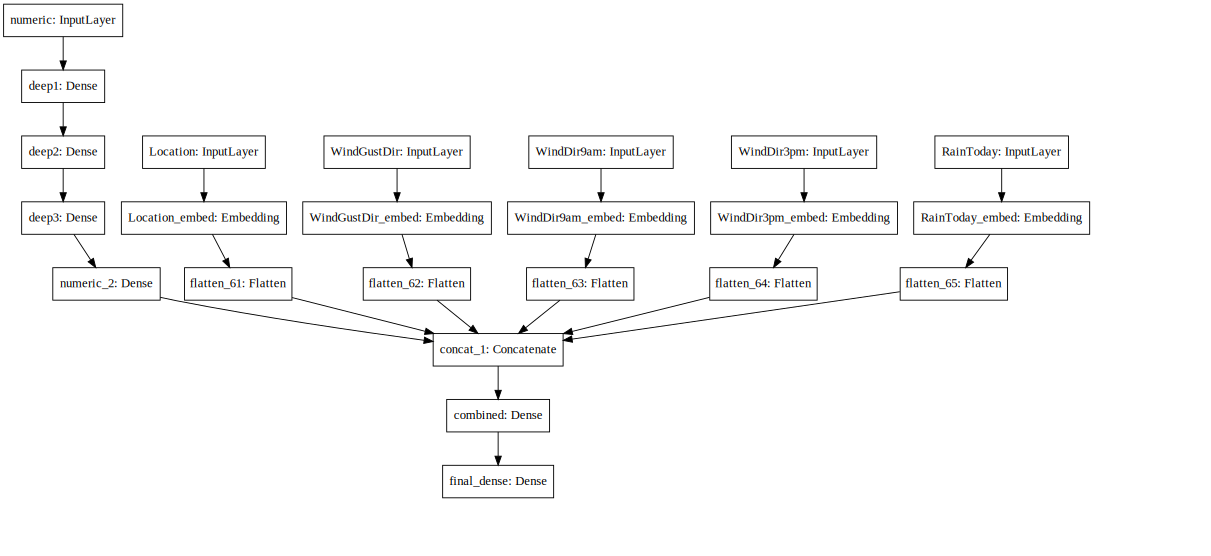

In [104]:
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

### Network Model 3: Crossovers

In [100]:
#TODO: we need to decide on our columns we think have relation? I dont even want to think about that right now tbh
#probably use f1 score because we want to get a good true positive vs negative rate for a binary classification.

### This is the standard wide/deep network that I made 
X_train_num =  encoded_train[numeric_cols].values
X_test_num = encoded_test[numeric_cols].values
dfs = []
dfs_test = []

# we need to create separate sequential models for each embedding
embed_branches = []
X_ints_train = [] # keep track of inputs for each branch
X_ints_test = []# keep track of inputs for each branch
all_inputs = [] # this is what we will give to keras.Model inputs
wide_branch_outputs = []
all_branch_outputs = [] 


encoders = dict() 
for col in categorical_cols:
    encoders[col] = LabelEncoder() # save the encoder
    print(encoded_train[col].values)
    encoded_train[col+'_int'] = encoders[col].fit_transform(encoded_train[col])
    encoded_test[col+'_int'] = encoders[col].transform(encoded_test[col])
#     print(encoded_train[col+"_int"])
    
    # encode as ints for the embedding
    X_ints_train.append( encoded_train[col + "_int" ].values ) # this df_train is a vector of the integers we are one hot encoding
    X_ints_test.append( encoded_test[col + "_int"].values )
    # get the number of categories
    N = max(X_ints_train[-1]+1) # same as the max(df_train[col]) grab the last column, whats the max value +1. this value tells us how many categories there are for that variable
    
    # create embedding branch from the number of categories
    inputs = Input(shape=(1,),dtype='int32', name=col)
    all_inputs.append( inputs ) # keep track of created inputs
    x = Embedding(input_dim=N, 
                  output_dim=int(np.sqrt(N)), 
                  input_length=1, name=col+'_embed')(inputs)
    x = Flatten()(x)
    wide_branch_outputs.append(x)
    
all_branch_outputs.append(concatenate(wide_branch_outputs, name='wide_concat'))

all_inputs.append(Input(shape=(X_train_num.shape[1],),sparse=False, name='numeric'))
x = Dense(units=40, activation='relu',name='numeric_1')(all_inputs[-1])
x = Dense(units=20, activation='relu',name='numeric_2')(all_inputs[-1])
all_branch_outputs.append( Dense(units=10,activation='relu', name='numeric_3')(x) )

# merge the branches together
final_branch = concatenate(all_branch_outputs, name='concat_1')
final_branch = Dense(units=1,activation='sigmoid', name='combined')(final_branch)

model = Model(inputs=all_inputs, outputs=final_branch)
print(model.summary())

['Cairns' 'Portland' 'PerthAirport' ... 'Dartmoor' 'Wollongong'
 'Wollongong']
87790      7
75519     29
117078    28
118127    27
137283    12
          ..
109605    41
54344      4
81150     11
42413     42
42752     42
Name: Location_int, Length: 90340, dtype: int64


/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/rbates/.local/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


['SE' 'WNW' 'NE' ... 'SW' 'S' 'SSW']
87790      9
75519     14
117078     4
118127    12
137283     4
          ..
109605     3
54344      5
81150     12
42413      8
42752     11
Name: WindGustDir_int, Length: 90340, dtype: int64
['SSE' 'NW' 'E' ... 'E' 'S' 'N']
87790     10
75519      7
117078     0
118127     2
137283     0
          ..
109605     3
54344      4
81150      0
42413      8
42752      3
Name: WindDir9am_int, Length: 90340, dtype: int64
['ESE' 'WNW' 'SE' ... 'SSW' 'SE' 'NE']
87790      2
75519     14
117078     9
118127     2
137283     2
          ..
109605     6
54344      5
81150     11
42413      9
42752      4
Name: WindDir3pm_int, Length: 90340, dtype: int64
['No' 'No' 'No' ... 'No' 'No' 'No']
87790     0
75519     0
117078    0
118127    0
137283    0
         ..
109605    0
54344     0
81150     0
42413     0
42752     0
Name: RainToday_int, Length: 90340, dtype: int64
Model: "model_10"
____________________________________________________________________________

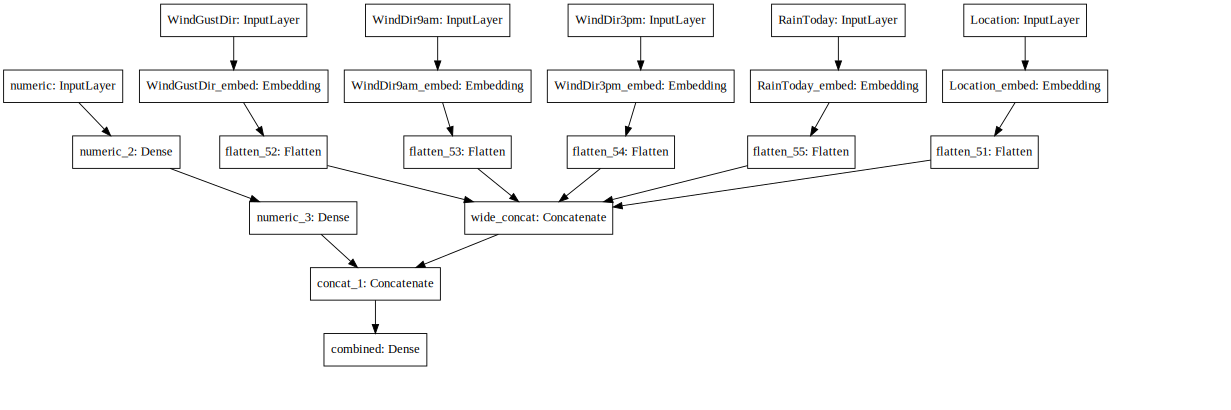

In [101]:
SVG(model_to_dot(model, dpi=65).create(prog='dot', format='svg'))

### Comparison

## Section 3: Exceptional Work

In [ ]:
import h5py
from sklearn.manifold import TSNE
which_weights = ['Location_embed','WindGustDir_embed', 'WindDir9am_embed', 'WindDir3pm_embed', 'numeric_1', 'numeric_2']
weights_2d = []
from keras.models import load_model
file_to_open = "model.hdf5"
f = h5py.File(file_to_open, 'r')
model = load_model(file_to_open)
for layer in model.layers:

    g=layer.get_config()
    h=layer.get_weights()
    if g['name'] in which_weights:
        weights_2d.append(TSNE(n_components=2).fit_transform(np.array(h[0])))
        print(h[0])

In [ ]:
colors = ["red", "blue", "green", "black", "cyan", "purple"]

import matplotlib.patches as mpatches
patches= []
for i in range(len(weights_2d)):
    patches.append (mpatches.Patch(color=colors[i], label=which_weights[i]))
    plt.scatter(weights_2d[i][:,0], weights_2d[i][:,1], color=colors[i], label=which_weights[i])
plt.legend(handles=patches)
plt.show()

Looking at all of the weights, we can see that there is only one cluster for certain embeded classes. The one that interests me the most is the WindDir3pm embeding. It looks like there is some clustering going on here since all of the weights are pretty clustered into the same location. This means that this item is very important regarding our classification.

Sadly, it does not look like there is too much clustering for any of the other columns. All of the other columns are spread out across their domain. I am surprised to see that WinDir9Am is much more spread out than the WindDir3pm column. I assume this means that the wind at 9am does not mean much for rain the following day rather than wind at 3pm.

#### The end.